In [1]:
import pymongo
import pandas as pd
import numpy as np
import re
import time
import datetime
import nltk
from datetime import datetime, timedelta
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from bson.objectid import ObjectId

In [2]:
client = pymongo.MongoClient('localhost',27017)
db = client.db
comments = db.comments
companies = db.companylist
matches = db.matches
chunks = db.chunks

df = pd.DataFrame.from_records(comments.find({'Label':{'$ne': 0}}))

In [4]:
import flair
from flair.models import TextClassifier
from flair.data import Sentence

In [5]:
labelDf = pd.DataFrame(columns = ['Label', 'Text'])
labelDf['Text'] = df['Body']
labelDf['Label'] = df['Label']

In [6]:
labelDf['Label'] = '__label__' + labelDf['Label'].astype(str)

In [7]:
labelDf = labelDf.sample(frac = 1)

In [8]:
labelDf.iloc[0: int(len(labelDf)*0.8)].to_csv('data/train.csv', sep = '\t', index = False, header = False)
labelDf.iloc[int(len(labelDf)*0.8): int(len(labelDf)*0.9)].to_csv('data/test.csv', sep = '\t', index = False, header = False)
labelDf.iloc[int(len(labelDf)*0.9): ].to_csv('data/dev.csv', sep = '\t', index = False, header = False)

In [9]:
from flair.datasets import ClassificationCorpus
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentRNNEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer
from pathlib import Path
corpus = ClassificationCorpus(Path('data/'), test_file='test.csv', dev_file='dev.csv', train_file='train.csv')
word_embeddings = [WordEmbeddings('glove'), FlairEmbeddings('news-forward-fast'), FlairEmbeddings('news-backward-fast')]
document_embeddings = DocumentRNNEmbeddings(word_embeddings, hidden_size=512, reproject_words=True, reproject_words_dimension=256)
classifier = TextClassifier(document_embeddings, label_dictionary=corpus.make_label_dictionary(), multi_label=False)
trainer = ModelTrainer(classifier, corpus)
trainer.train('model/', max_epochs=10)

2020-11-05 15:52:31,898 Reading data from data
2020-11-05 15:52:31,899 Train: data/train.csv
2020-11-05 15:52:31,900 Dev: data/dev.csv
2020-11-05 15:52:31,901 Test: data/test.csv
2020-11-05 15:52:33,516 Computing label dictionary. Progress:
100%|██████████| 5424/5424 [00:01<00:00, 3443.25it/s]2020-11-05 15:52:36,794 [b'neutral', b'bullish', b'bearish']
2020-11-05 15:52:36,800 ----------------------------------------------------------------------------------------------------
2020-11-05 15:52:36,808 Model: "TextClassifier(
  (document_embeddings): DocumentRNNEmbeddings(
    (embeddings): StackedEmbeddings(
      (list_embedding_0): WordEmbeddings('glove')
      (list_embedding_1): FlairEmbeddings(
        (lm): LanguageModel(
          (drop): Dropout(p=0.25, inplace=False)
          (encoder): Embedding(275, 100)
          (rnn): LSTM(100, 1024)
          (decoder): Linear(in_features=1024, out_features=275, bias=True)
        )
      )
      (list_embedding_2): FlairEmbeddings(
      

OSError: [Errno 12] Cannot allocate memory

In [1]:
from flair.models import TextClassifier
from flair.data import Sentence
classifier = TextClassifier.load('model/best-model.pt')

2020-11-05 19:55:43,869 loading file model/best-model.pt


In [10]:
sentence = Sentence("drill team six")
classifier.predict(sentence)
sentence.labels[0].to_dict()

{'value': 'neutral', 'confidence': 0.4739326536655426}

In [5]:
df = pd.DataFrame.from_records(db.threads.find({'Label':{'$ne': 0}}))

In [12]:
count = 0
for i in df['Body']:
    print(count)
    doc = i
    strings = doc.split('. ')
    for sent in strings:
        sentence = Sentence(sent)
        classifier.predict(sentence)
        print(sentence.labels)
    count = count + 1

0
[bullish (0.4264)]
[bearish (0.4014)]
[bullish (0.3883)]
[neutral (0.361)]
[neutral (0.5081)]
[neutral (0.4587)]
[neutral (0.5477)]
[neutral (0.6959)]
[neutral (0.4369)]
1
[neutral (0.4986)]
[bullish (0.4714)]
[neutral (0.3696)]
[bullish (0.469)]
[bearish (0.4374)]
[bullish (0.583)]
[neutral (0.5378)]
[neutral (0.4533)]
[bullish (0.3903)]
[neutral (0.4696)]
[neutral (0.5345)]
[bullish (0.3929)]
[bearish (0.4591)]
[bearish (0.4687)]
[bullish (0.6079)]
[bullish (0.5661)]
[bullish (0.4594)]
[neutral (0.4239)]
[bullish (0.3992)]
[bullish (0.3883)]
[bullish (0.3863)]
[neutral (0.4566)]
[bearish (0.4039)]
[neutral (0.4199)]
[neutral (0.6094)]
[neutral (0.6532)]
[neutral (0.3901)]
2
[neutral (0.4543)]
[neutral (0.4557)]
[bullish (0.485)]
[bearish (0.4268)]
[bullish (0.4372)]
[neutral (0.3578)]
[neutral (0.6233)]
[bearish (0.4631)]
[neutral (0.3811)]
[neutral (0.5655)]
[neutral (0.5073)]
[neutral (0.3623)]
[neutral (0.5085)]
[neutral (0.5124)]
[neutral (0.6283)]
[neutral (0.4525)]
3
[bullish

KeyboardInterrupt: 

In [13]:
sentence.labels

[]

Learning_rate plots are saved in model/learning_rate.png


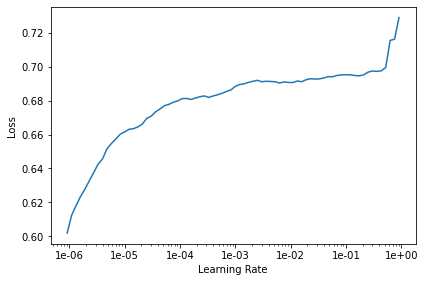

In [3]:
from flair.visual.training_curves import Plotter
plotter = Plotter()
plotter.plot_learning_rate('model/learning_rate.tsv')